In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class UnnormedMVNormalPDF:

    def __init__(self, eigvecs):
        if not isinstance(eigvecs, np.ndarray):
            eigvecs = np.array(eigvecs)
        self.eigvecs = eigvecs
        self.cov = eigvecs.T @ eigvecs
        self.cov_inv = np.linalg.inv(self.cov)

    def __call__(self, x):
        if not isinstance(x, np.ndarray):
            x = np.array(x)
        x = x.reshape(-1, 2)
        val = x @ self.cov_inv
        val = (val * x).sum(axis=1)
        return np.exp(-0.5 * val)


class Overlap:

    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def __call__(self, x):
        z_a = self.a(x)
        z_b = self.b(x)
        z = np.stack([z_a, z_b], axis=-1).min(axis=-1)
        return z
    
    
class Intersection:

    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def __call__(self, x):
        z_a = self.a(x)
        z_b = self.b(x)
        z = np.sqrt(z_a * z_b)
        return z


class Difference:

    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def __call__(self, x):
        z_a = self.a(x)
        z_b = self.b(x)
        z = np.abs(z_a - z_b)
        return z


class MVNormalOverlapApprox:

    def __init__(self, a, b):
        self.dist = UnnormedMVNormalPDF([[1, 1], [-1, 1]])
        
    def __call__(self, x):
        return self.dist(x)
    

def plot_pdf(ax, func, lim, resolution=100):
    x = np.linspace(-lim, lim, resolution)
    y = np.linspace(-lim, lim, resolution)
    X, Y = np.meshgrid(x, y)
    Z = func(np.stack([X.reshape(-1), 
                       Y.reshape(-1)], 
                      axis=1)).reshape(X.shape)
    
    cnt = ax.contourf(X, Y, Z, levels=10, vmin=0, vmax=1, cmap='Blues', alpha=0.5, linestyles=None)
    for c in cnt.collections:
        c.set_edgecolor("face")


def plot_eigvecs(ax, eigvecs):
    ax.quiver([0, 0], [0, 0], eigvecs[:, 0], eigvecs[:, 1], scale_units='xy', scale=1)

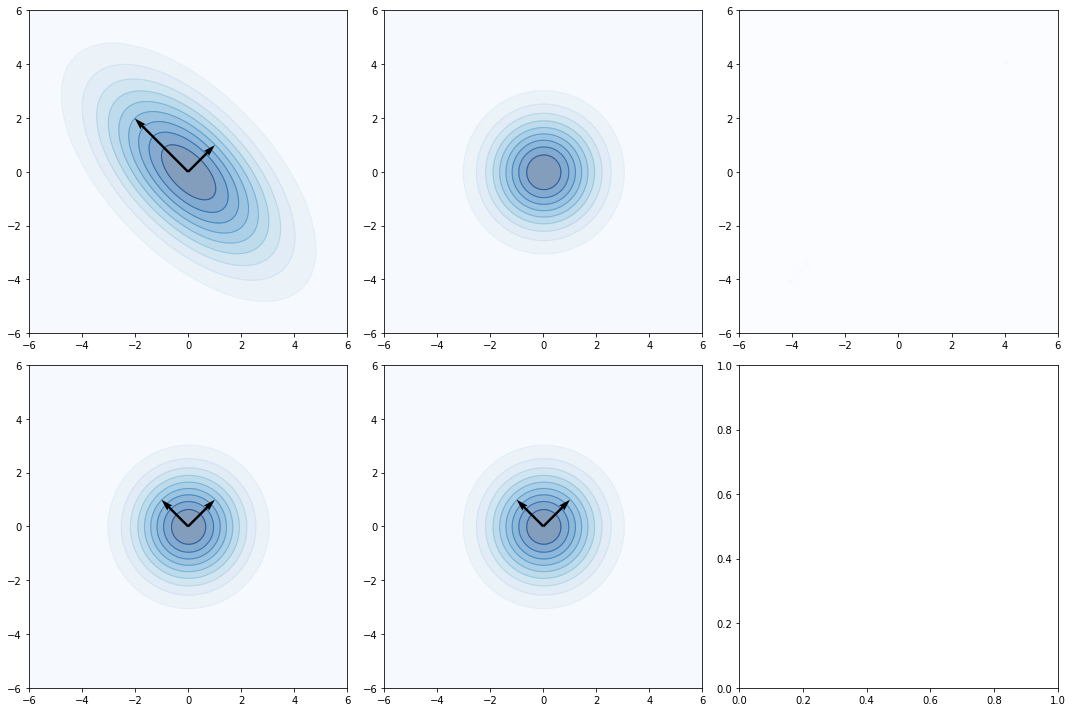

In [4]:
a = UnnormedMVNormalPDF([[1, 1], [-2, 2]])
b = UnnormedMVNormalPDF([[1, 1], [-1, 1]])
aOb = Overlap(a, b)
aOb_approx = MVNormalOverlapApprox(a, b)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

plot_pdf(axs[0, 0], a, 6)
plot_eigvecs(axs[0, 0], a.eigvecs)

plot_pdf(axs[1, 0], b, 6)
plot_eigvecs(axs[1, 0], b.eigvecs)

plot_pdf(axs[0, 1], aOb, 6)

plot_pdf(axs[1, 1], aOb_approx, 6)
plot_eigvecs(axs[1, 1], aOb_approx.dist.eigvecs)

plot_pdf(axs[0, 2], Difference(aOb, aOb_approx), 6)

fig.tight_layout()
plt.show()